In [1]:
import resource
resource.setrlimit(resource.RLIMIT_DATA, (2**35, 2**35))

In [2]:
from devito import *
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
from segysak.segy import (
    segy_loader,
    get_segy_texthead,
    segy_header_scan,
    segy_header_scrape,
    well_known_byte_locs,
)
import xarray as xr
from examples.seismic import SeismicModel, plot_velocity
from examples.seismic.source import RickerSource, Receiver, TimeAxis

# Some ploting setup
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

In [3]:
filepath = {'rho' : 'Modeling_data/Rho_model3D-cut.sgy',
            'vp' : 'Modeling_data/Vp_model3D-cut.sgy', 
            'vs' : 'Modeling_data/Vs_model3D-cut.sgy'}

In [4]:
#сегваи
cube_rho = segy_loader(filepath['rho'], **well_known_byte_locs('petrel_3d'))
cube_vp = segy_loader(filepath['vp'], **well_known_byte_locs('petrel_3d'))
cube_vs = segy_loader(filepath['vs'], **well_known_byte_locs('petrel_3d'))

/tmp/ipykernel_26375/3294394779.py:2: DeprecationWarning: segy_loader will be removed in v0.6, please use the Xarray engine ds = xr.open_dataset(segy_file) method instead.
  cube_rho = segy_loader(filepath['rho'], **well_known_byte_locs('petrel_3d'))


  0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

  0%|          | 0.00/10.2k [00:00<?, ? traces/s]

Loading as 3D
Fast direction is CDP


Converting SEGY:   0%|          | 0.00/10.2k [00:00<?, ? traces/s]

/tmp/ipykernel_26375/3294394779.py:3: DeprecationWarning: segy_loader will be removed in v0.6, please use the Xarray engine ds = xr.open_dataset(segy_file) method instead.
  cube_vp = segy_loader(filepath['vp'], **well_known_byte_locs('petrel_3d'))


  0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

  0%|          | 0.00/10.2k [00:00<?, ? traces/s]

Loading as 3D
Fast direction is CDP


Converting SEGY:   0%|          | 0.00/10.2k [00:00<?, ? traces/s]

/tmp/ipykernel_26375/3294394779.py:4: DeprecationWarning: segy_loader will be removed in v0.6, please use the Xarray engine ds = xr.open_dataset(segy_file) method instead.
  cube_vs = segy_loader(filepath['vs'], **well_known_byte_locs('petrel_3d'))


  0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

  0%|          | 0.00/10.2k [00:00<?, ? traces/s]

Loading as 3D
Fast direction is CDP


Converting SEGY:   0%|          | 0.00/10.2k [00:00<?, ? traces/s]

In [5]:
#Найдем частоту дискретизации
header_rho = segy_header_scan(filepath['rho'])
header_rho.loc["TRACE_SAMPLE_INTERVAL", "mean"]

  0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

  0%|          | 0.00/1.00k [00:00<?, ? traces/s]

np.float64(2000.0)

In [6]:
segy_header_scrape(filepath['rho'])["TRACE_SAMPLE_INTERVAL"]

  0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

  0%|          | 0.00/10.2k [00:00<?, ? traces/s]

0        2000
1        2000
2        2000
3        2000
4        2000
         ... 
10196    2000
10197    2000
10198    2000
10199    2000
10200    2000
Name: TRACE_SAMPLE_INTERVAL, Length: 10201, dtype: int16

In [7]:
rho_data = (cube_rho.data[:,:,:250]).to_numpy()
vp_data = (cube_vp.data[:,:,:250]).to_numpy()
vs_data = (cube_vs.data[:,:,:250]).to_numpy()

In [8]:
cube_rho.data.shape

(101, 101, 501)

# Как это выглядит

In [9]:
#Rho
# grid_rho = pv.ImageData()
# grid_rho.dimensions = np.array(rho_data.shape) + 1
# grid_rho.cell_data['Values'] = rho_data.flatten(order='F')
# grid_rho.plot()

In [10]:
#Vp
# grid_vp = pv.ImageData()
# grid_vp.dimensions = np.array(vp_data.shape) + 1
# grid_vp.cell_data['Values'] = vp_data.flatten(order='F')
# grid_vp.plot()

In [11]:
#Vs
# grid_vs = pv.ImageData()
# grid_vs.dimensions = np.array(vs_data.shape) + 1
# grid_vs.cell_data['Values'] = vs_data.flatten(order='F')
# grid_vs.plot()

In [12]:
# plt.plot(cube_rho.cdp_x.data, cube_rho.cdp_y.data)

# Моделирование

In [13]:
shape = rho_data.shape
spacing = (25., 25., 2) # z из header_rho.loc["TRACE_SAMPLE_INTERVAL", "mean"]
origin = (0, 0, 0)
nbl = 20
so = 2

rho_data_nozero = np.where(rho_data == 0, 1, rho_data)

In [14]:
model = SeismicModel(origin = origin, 
                     spacing = spacing, 
                     shape = shape, 
                     vp = vp_data,
                     vs = vs_data,
                     b = 1/rho_data_nozero,
                     space_order = so,
                     nbl=nbl,
                     bcs="damp"
                    )


Operator `initdamp` ran in 0.01 s


Проверим загрузку данных по коэфф ламе

In [15]:
#функция для поиска индекса поверхности
def surface_indecies(arr, axis=2, invalid_val=-1):
    mask = arr!=0
    return np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)

surface_index = surface_indecies(model.lam.data[nbl:-nbl, nbl:-nbl, nbl:-nbl])

In [16]:
model.critical_dt

np.float32(0.0003647)

In [17]:
#наша поверхность
# plt.imshow(surface_index)

In [18]:
# grid_lam = pv.ImageData()
# grid_lam.dimensions = np.array(model.shape)+1
# grid_lam.cell_data['Values'] = np.flip(model.lam.data[nbl:-nbl, nbl:-nbl, nbl:-nbl].flatten(order='F'))
# grid_lam.plot()

In [19]:
t0, tn = 0., 1000.
dt = model.critical_dt 
time_range = TimeAxis(start=t0, stop=tn, step=dt)

src = RickerSource(name='src', grid = model.grid, f0=0.015, time_range=time_range)
src.coordinates.data[:] = [1250, 1250, surface_index[50,50]*2]

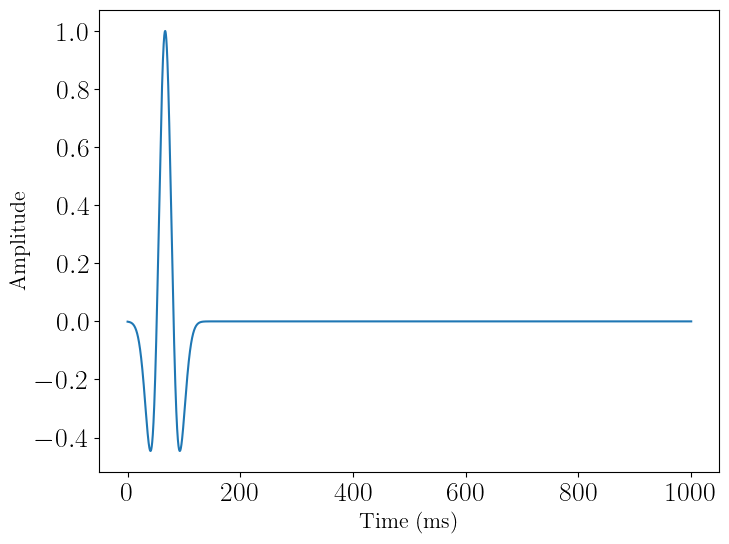

In [20]:
src.show()

## Зададим оператор

In [21]:
#create velocity and pressure fields
s = model.grid.time_dim.spacing

v = VectorTimeFunction(name='v', grid=model.grid, space_order=so, time_order=1)
tau = TensorTimeFunction(name='t', grid=model.grid, space_order=so, time_order=1)

In [22]:
#transform from mxn array to 3xm*n. Also convert from indicies to meters
def coord_transform(arr):
    value = arr.flatten()
    y, x = np.indices(arr.shape).reshape(-1, len(value))
    return np.vstack((x,y,value)).T*np.array([25,25,2])
surface_depth = coord_transform(surface_index)

In [23]:
# The source injection term
src_xx = src.inject(field=tau.forward[0, 0], expr=s*src)
src_yy = src.inject(field=tau.forward[1, 1], expr=s*src)
src_zz = src.inject(field=tau.forward[2, 2], expr=s*src)

# The receiver
nrec = model.shape[0]*model.shape[1]

rec = Receiver(name="rec", grid=model.grid, npoint=nrec, time_range=time_range)
rec.coordinates.data[:,0] = surface_depth[:,0]
rec.coordinates.data[:,1] = surface_depth[:,1]
rec.coordinates.data[:,2] = surface_depth[:,2] - 1

rec2 = Receiver(name="rec", grid=model.grid, npoint=nrec, time_range=time_range)
rec2.coordinates.data[:,0] = surface_depth[:,0]
rec2.coordinates.data[:,1] = surface_depth[:,1]
rec2.coordinates.data[:,2] = surface_depth[:,2] - 1

rec3 = Receiver(name="rec", grid=model.grid, npoint=nrec, time_range=time_range)
rec3.coordinates.data[:,0] = surface_depth[:,0]
rec3.coordinates.data[:,1] = surface_depth[:,1]
rec3.coordinates.data[:,2] = surface_depth[:,2] - 1

rec_term = rec.interpolate(expr=v[2])
rec_term += rec2.interpolate(expr=v[1])
rec_term += rec3.interpolate(expr=v[0])

In [24]:
# pv.set_jupyter_backend('client')
# point_cloud = pv.PolyData(np.vstack((rec.coordinates.data, src.coordinates.data)))
# scalars = np.append(np.zeros(10201), 1)
# point_cloud.plot(scalars=scalars)

In [25]:
# Now let's try and create the staggered updates
# Lame parameters
l, mu, ro = model.lam, model.mu, model.b

# First order elastic wave equation
pde_v = v.dt - ro * div(tau)
pde_tau = tau.dt - l * diag(div(v.forward)) - mu * (grad(v.forward) + grad(v.forward).transpose(inner=False))
# Time update
u_v = Eq(v.forward, model.damp * solve(pde_v, v.forward))
u_t = Eq(tau.forward,  model.damp * solve(pde_tau, tau.forward))

op = Operator([u_v] + [u_t] + src_xx + src_yy + src_zz + rec_term)

In [26]:
u_v

Eq(Vector(v_x(t + dt, x + h_x/2, y, z), v_y(t + dt, x, y + h_y/2, z), v_z(t + dt, x, y, z + h_z/2)), Vector(dt*((Derivative(t_xx(t, x, y, z), x) + Derivative(t_xy(t, x + h_x/2, y + h_y/2, z), y) + Derivative(t_xz(t, x + h_x/2, y, z + h_z/2), z))*b(x, y, z) + v_x(t, x + h_x/2, y, z)/dt)*damp(x, y, z), dt*((Derivative(t_xy(t, x + h_x/2, y + h_y/2, z), x) + Derivative(t_yy(t, x, y, z), y) + Derivative(t_yz(t, x, y + h_y/2, z + h_z/2), z))*b(x, y, z) + v_y(t, x, y + h_y/2, z)/dt)*damp(x, y, z), dt*((Derivative(t_xz(t, x + h_x/2, y, z + h_z/2), x) + Derivative(t_yz(t, x, y + h_y/2, z + h_z/2), y) + Derivative(t_zz(t, x, y, z), z))*b(x, y, z) + v_z(t, x, y, z + h_z/2)/dt)*damp(x, y, z)))

In [27]:
u_t

Eq(Matrix([[t_xx(t + dt, x, y, z), t_xy(t + dt, x + h_x/2, y + h_y/2, z), t_xz(t + dt, x + h_x/2, y, z + h_z/2)], [t_xy(t + dt, x + h_x/2, y + h_y/2, z), t_yy(t + dt, x, y, z), t_yz(t + dt, x, y + h_y/2, z + h_z/2)], [t_xz(t + dt, x + h_x/2, y, z + h_z/2), t_yz(t + dt, x, y + h_y/2, z + h_z/2), t_zz(t + dt, x, y, z)]]), Matrix([[dt*((Derivative(v_x(t + dt, x + h_x/2, y, z), x) + Derivative(v_y(t + dt, x, y + h_y/2, z), y) + Derivative(v_z(t + dt, x, y, z + h_z/2), z))*lam(x, y, z) + 2*mu(x, y, z)*Derivative(v_x(t + dt, x + h_x/2, y, z), x) + t_xx(t, x, y, z)/dt)*damp(x, y, z), dt*((Derivative(v_x(t + dt, x + h_x/2, y, z), y) + Derivative(v_y(t + dt, x, y + h_y/2, z), x))*mu(x, y, z) + t_xy(t, x + h_x/2, y + h_y/2, z)/dt)*damp(x, y, z), dt*((Derivative(v_x(t + dt, x + h_x/2, y, z), z) + Derivative(v_z(t + dt, x, y, z + h_z/2), x))*mu(x, y, z) + t_xz(t, x + h_x/2, y, z + h_z/2)/dt)*damp(x, y, z)], [dt*((Derivative(v_x(t + dt, x + h_x/2, y, z), y) + Derivative(v_y(t + dt, x, y + h_y/2, z)

In [28]:
#NBVAL_IGNORE_OUTPUT
op(dt=model.critical_dt) 

RuntimeError: Unable to allocate 27970948181 elements in memory